In [30]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from sweref99 import projections
import folium
from folium import plugins
from selenium import webdriver
import branca
import requests
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output

In [31]:
path='./data/Insatser till brand i skog och mark 2000-2020.xlsx'

In [32]:
#tm is used for the conversions of easting and northing to longitude and latitude
tm = projections.make_transverse_mercator("SWEREF_99_TM")

In [33]:
df = pd.read_excel(path)


In [34]:
#Here are our headers!
df['TotArea'] = df['arealProduktivSkogsmark_m2']+df['arealAnnanTradbevuxenMark_m2']+df['arealMarkUtanTrad_m2']
df['Acres'] = df['TotArea']/4046.86
df.head(1)


,ar,datum,tid,kommun,kommunKortNamn,verksamhetText,sweref99Norr,sweref99Ost,BEJBbrandorsakText,arealProduktivSkogsmark_m2,arealAnnanTradbevuxenMark_m2,arealMarkUtanTrad_m2,TotArea,Acres
0,2000,2000-01-01,00:07:00,1272,Bromölla,Verksamhet inte knuten till en byggnad,6856.0,-905921.0,Fyrverkeri eller pyroteknik,0,6,0,6,0.001483


In [35]:
        df['Month'] = df['datum'].dt.month
        df['Year'] = df['datum'].dt.year
        df

,ar,datum,tid,kommun,kommunKortNamn,verksamhetText,sweref99Norr,sweref99Ost,BEJBbrandorsakText,arealProduktivSkogsmark_m2,arealAnnanTradbevuxenMark_m2,arealMarkUtanTrad_m2,TotArea,Acres,Month,Year
0,2000,2000-01-01,00:07:00,1272,Bromölla,Verksamhet inte knuten till en byggnad,6856.0,-905921.0,Fyrverkeri eller pyroteknik,0,6,0,6,0.001483,1,2000
1,2000,2000-01-01,01:04:00,1452,Tranemo,Verksamhet inte knuten till en byggnad,NaN,NaN,Okänd,0,0,5,5,0.001236,1,2000
2,2000,2000-01-02,01:05:00,2283,Sollefteå,"Lantbruk, inte bostad",NaN,NaN,Annan,0,0,15000,15000,3.706577,1,2000
3,2000,2000-01-02,19:35:00,180,Stockholm,Verksamhet inte knuten till en byggnad,NaN,NaN,Okänd,0,5,0,5,0.001236,1,2000
4,2000,2000-01-03,12:37:00,180,Stockholm,Verksamhet inte knuten till en byggnad,NaN,NaN,Barns lek med eld,0,50,0,50,0.012355,1,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100302,2020,2020-12-29,01:52:00,180,Stockholm,Verksamhet inte knuten till en byggnad,6586007.0,664319.0,Avsiktlig brand,0,1,0,1,0.000247,12,2020
100303,2020,2020-12-29,18:56:00,117,Österåker,Verksamhet inte knuten till en byggnad,6599203.0,687136.0,Avsiktlig brand,0,0,1,1,0.000247,12,2020
100304,2020,2020-12-30,12:32:00,380,Uppsala,Verksamhet inte knuten till en byggnad,6637240.0,653312.0,Okänd,0,0,20,20,0.004942,12,2020
100305,2020,2020-12-31,15:17:00,1384,Kungsbacka,Verksamhet inte knuten till en byggnad,6360762.0,327099.0,Annan,0,0,1,1,0.000247,12,2020


In [36]:
print(df.shape)


(100307, 16)


In [37]:
#Here I copy the dataframe to not have to read the csv files if i accidently overwrites the dataframe.
copy_df = df

In [38]:
#Getting all causes for a fire 
copy_df['BEJBbrandorsakText'].unique()

array(['Fyrverkeri eller pyroteknik', 'Okänd', 'Annan',
       'Barns lek med eld', 'Annan eldning', 'Avsiktlig brand',
       'Övriga gnistor',
       'Återantändning av brand från tidigare räddningsinsats',
       'Självantändning - biologisk eller kemisk',
       'Grillning eller lägereld', 'Blixtnedslag', 'Heta arbeten',
       'Rökning', 'Tågbromsning', 'Fel i utrustning', 'Uppgift saknas'],
      dtype=object)

In [39]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [40]:
#Filter rows on cause of fire and only keeping "Annan". "Okänd", "Grillning eller lägereld" and "Uppgift saknas"
copy_df = filter_rows_by_values(copy_df, 'BEJBbrandorsakText', ['Fyrverkeri eller pyroteknik', 'Annan',
       'Barns lek med eld', 'Annan eldning', 'Avsiktlig brand',
       'Övriga gnistor',
       'Återantändning av brand från tidigare räddningsinsats',
       'Självantändning - biologisk eller kemisk', 'Blixtnedslag', 'Heta arbeten',
       'Rökning', 'Tågbromsning', 'Fel i utrustning', 'Uppgift saknas'])

In [41]:
#I drop all fires smaller than one acre and only keep fires that . I check how many fires are left.
#copy_df = copy_df[copy_df.Acres>1]
#copy_df = copy_df
print(copy_df.shape)

(45922, 16)


In [42]:
#To not get to many values I have made a random sample of X fires.
sample = copy_df#.sample(25, replace=True)

In [43]:
for column in sample:
    if sample[column].isnull().any():
       print('{0} has {1} null values'.format(column, sample[column].isnull().sum()))

sweref99Norr has 9118 null values
sweref99Ost has 9117 null values


In [44]:
#Function that calculates number of missing data in column of dataframe and prints result.
def missing(df,column):
       x = len(df)
       if df[column].isnull().any():
           print('{0} has total of {1} null values'.format(column, df[column].isnull().sum()))
           print ('In the column {0}'.format(column), round(100-(df[column].count()/x * 100), 3), '% of the cells have missing values')
 

In [45]:
#Missing values of column:
missing(sample,'sweref99Norr')
missing(sample,'sweref99Ost')
sample.isnull().sum(axis = 0)

sweref99Norr has total of 9118 null values
In the column sweref99Norr 19.855 % of the cells have missing values
sweref99Ost has total of 9117 null values
In the column sweref99Ost 19.853 % of the cells have missing values


ar                                 0
datum                              0
tid                                0
kommun                             0
kommunKortNamn                     0
verksamhetText                     0
sweref99Norr                    9118
sweref99Ost                     9117
BEJBbrandorsakText                 0
arealProduktivSkogsmark_m2         0
arealAnnanTradbevuxenMark_m2       0
arealMarkUtanTrad_m2               0
TotArea                            0
Acres                              0
Month                              0
Year                               0
dtype: int64

In [46]:
#Functions for converting easting and northing to latitudes and longitudes.
def toLat(E,N):
    lat, lon = tm.grid_to_geodetic(N,E)
    return lat
def toLon(E,N):
    lat, lon = tm.grid_to_geodetic(N,E)
    return lon

In [47]:
#Applying functions to create to new columns, Longitude and Latitude for reported fires.
sample['Latitude'] = sample.apply(lambda row: toLat(row['sweref99Ost'],row['sweref99Norr']),axis=1)
sample['Longitude'] = sample.apply(lambda row: toLon(row['sweref99Ost'],row['sweref99Norr']),axis=1)

C:\Users\Johan\AppData\Local\Temp/ipykernel_13904/1364981563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Latitude'] = sample.apply(lambda row: toLat(row['sweref99Ost'],row['sweref99Norr']),axis=1)
C:\Users\Johan\AppData\Local\Temp/ipykernel_13904/1364981563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Longitude'] = sample.apply(lambda row: toLon(row['sweref99Ost'],row['sweref99Norr']),axis=1)


In [48]:
#We need to group fire sizes here but what sizes should we use? What is a "big" fire and what is a "small" fire?
sample['TotArea'].describe()

count    4.592200e+04
mean     2.839255e+03
std      5.302926e+04
min      0.000000e+00
25%      4.000000e+00
50%      2.200000e+01
75%      2.000000e+02
max      5.500000e+06
Name: TotArea, dtype: float64

In [49]:
#New df for dates and fires
firesAndDates = pd.DataFrame(columns=['datum','fires'])

In [50]:
#Set dates column to the datum columns from the sample
firesAndDates['datum'] = sample['datum']

In [51]:
firesAndDates

,datum,fires
1,2000-01-01,NaN
3,2000-01-02,NaN
5,2000-01-04,NaN
6,2000-01-05,NaN
7,2000-01-08,NaN
...,...,...
100289,2020-12-14,NaN
100290,2020-12-17,NaN
100292,2020-12-19,NaN
100298,2020-12-27,NaN


In [52]:
#Set month and year column to month and year values from datum column
firesAndDates['Month'] = firesAndDates['datum'].dt.month
firesAndDates['Year'] = firesAndDates['datum'].dt.year

In [53]:
#Set all values for fires column to 1
firesAndDates= firesAndDates.assign(fires=1)

In [54]:
firesAndDates['day'] = firesAndDates['datum'].dt.day
firesAndDates['month'] = firesAndDates['datum'].dt.month


In [55]:
fires_month = pd.DataFrame(columns=['Month','Sum'])

In [56]:

fires_month['Sum'] = firesAndDates['Month'].value_counts().to_frame()


In [57]:
fires_day_month = pd.DataFrame(columns=['month_name','Sum'])


In [58]:
firesAndDates

,datum,fires,Month,Year,day,month
1,2000-01-01,1,1,2000,1,1
3,2000-01-02,1,1,2000,2,1
5,2000-01-04,1,1,2000,4,1
6,2000-01-05,1,1,2000,5,1
7,2000-01-08,1,1,2000,8,1
...,...,...,...,...,...,...
100289,2020-12-14,1,12,2020,14,12
100290,2020-12-17,1,12,2020,17,12
100292,2020-12-19,1,12,2020,19,12
100298,2020-12-27,1,12,2020,27,12


In [62]:
fires_day_month

,,,month_name,Sum
day,month,Year,,
22,5,2019,NaN,161
20,4,2003,NaN,123
21,4,2003,NaN,99
9,6,2008,NaN,91
10,6,2008,NaN,90
...,...,...,...,...
15,9,2006,NaN,1
19,4,2016,NaN,1
15,9,2001,NaN,1


In [61]:
fires_day_month['Sum'] = firesAndDates.value_counts(['day','month','Year']).to_frame()
fires_day_month.reset_index()

,day,month,Year,month_name,Sum
0,22,5,2019,NaN,161
1,20,4,2003,NaN,123
2,21,4,2003,NaN,99
3,9,6,2008,NaN,91
4,10,6,2008,NaN,90
...,...,...,...,...,...
5103,15,9,2006,NaN,1
5104,19,4,2016,NaN,1
5105,15,9,2001,NaN,1
5106,15,8,2013,NaN,1


In [86]:
#GHEHRHERHERHERHERHERH
fires_day_month = fires_day_month.reset_index()

In [87]:
fires_month['Month_num'] = fires_month.index

In [88]:
month_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


In [89]:
fires_month['Month'] = fires_month['Month_num'].apply(lambda x: month_labels[x])

In [90]:
fires_day_month['month_name'] = fires_day_month['month'].apply(lambda x: month_labels[x])

In [91]:
fires_month.sort_values(by=['Month_num'], inplace=True)
fires_month = fires_month.reset_index(drop=True)

In [92]:
fires_month.drop(columns=['Month_num'], inplace=True)


In [93]:
plt.rcParams["figure.figsize"] = (18,8)

In [94]:

fig = fires_day_month.groupby(['month','Year']).sum().unstack()

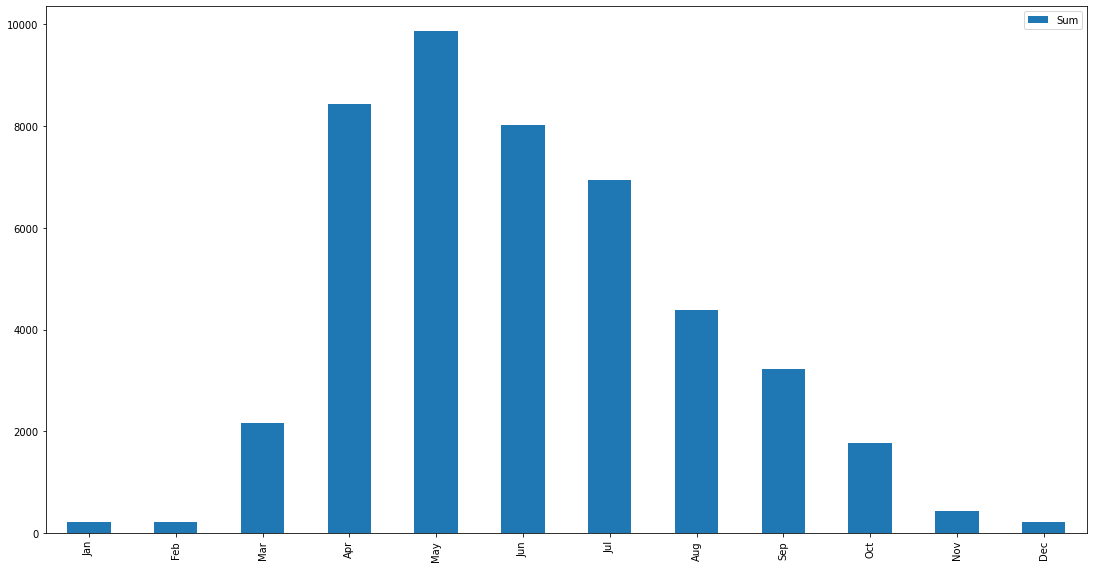

In [95]:
ax = fires_month.plot(kind="bar")
ax.set_xticklabels(fires_month['Month'].values)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [96]:
fires_day_month['date'] = pd.to_datetime({'year':fires_day_month['Year'],'month': fires_day_month['month'],'day':fires_day_month['day']})
fires_day_month['yday'] = fires_day_month['date'].dt.dayofyear
fires_day_month.sort_values('yday')

,day,month,Year,month_name,Sum,date,yday
5107,1,1,2000,Jan,1,2000-01-01,1
3838,1,1,2010,Jan,2,2010-01-01,1
3808,1,1,2016,Jan,2,2016-01-01,1
3805,1,1,2014,Jan,2,2014-01-01,1
1348,1,1,2020,Jan,11,2020-01-01,1
...,...,...,...,...,...,...,...
3820,31,12,2018,Dec,2,2018-12-31,365
4251,30,12,2016,Dec,1,2016-12-30,365
1951,31,12,2016,Dec,7,2016-12-31,366
3147,31,12,2008,Dec,3,2008-12-31,366


In [97]:
#You are here
tablesplit = fires_day_month.set_index(['date'])
pre2019 = tablesplit.loc['2000-1-1':'2018-12-31']
pre2019['year_group'] = '2000-2018'
post2018 = tablesplit.loc['2019-1-1' : '2020-12-31']
post2018['year_group'] = '2019-2020 '
fires12to18 = tablesplit.loc['2012-1-1' : '2018-12-31']
post2018.sort_values(by='yday')
fires_day_month_v2 = pd.concat([pre2019,post2018])


In [98]:
fires_day_month_v2= fires_day_month_v2.reset_index()
fires_day_month_v2 = fires_day_month_v2.sort_values(by='date')

In [99]:
#Creates two tables. One is between 2000 and 2018 (before disposable grill ban), and the second is 2019-2020 (after disposable grill ban)
fires_day_month_v2['rol7'] = fires_day_month_v2[['date','Sum']].rolling(7).mean()
fires_day_month_v2.head(10)

,date,day,month,Year,month_name,Sum,yday,year_group,rol7
4569,2000-01-01,1,1,2000,Jan,1,1,2000-2018,NaN
3690,2000-01-02,2,1,2000,Jan,1,2,2000-2018,NaN
3853,2000-01-04,4,1,2000,Jan,1,4,2000-2018,NaN
3647,2000-01-05,5,1,2000,Jan,1,5,2000-2018,NaN
4531,2000-01-08,8,1,2000,Jan,1,8,2000-2018,NaN
4468,2000-01-15,15,1,2000,Jan,1,15,2000-2018,NaN
2988,2000-01-16,16,1,2000,Jan,3,16,2000-2018,1.285714
3535,2000-01-17,17,1,2000,Jan,2,17,2000-2018,1.428571
2282,2000-01-18,18,1,2000,Jan,4,18,2000-2018,1.857143
3526,2000-01-20,20,1,2000,Jan,2,20,2000-2018,2.000000


In [100]:
fig3 = fires_day_month.groupby(['yday','Year']).sum().unstack()
fig3

day                                                   ...  Sum       \
Year 2000 2001  2002 2003  2004 2005 2006  2007  2008 2009  ... 2011 2012   
yday                                                        ...             
1     1.0  NaN   NaN  NaN   1.0  NaN  NaN   NaN   1.0  1.0  ...  NaN  2.0   
2     2.0  2.0   NaN  NaN   NaN  2.0  2.0   2.0   NaN  NaN  ...  NaN  NaN   
3     NaN  3.0   NaN  3.0   NaN  3.0  NaN   NaN   NaN  NaN  ...  NaN  NaN   
4     4.0  NaN   NaN  NaN   NaN  NaN  NaN   NaN   4.0  4.0  ...  NaN  NaN   
5     5.0  NaN   NaN  NaN   NaN  5.0  NaN   NaN   NaN  5.0  ...  NaN  NaN   
...   ...  ...   ...  ...   ...  ...  ...   ...   ...  ...  ...  ...  ...   
362   NaN  NaN  28.0  NaN   NaN  NaN  NaN   NaN   NaN  NaN  ...  3.0  NaN   
363   NaN  NaN   NaN  NaN  28.0  NaN  NaN  29.0  28.0  NaN  ...  NaN  NaN   
364   NaN  NaN   NaN  NaN   NaN  NaN  NaN   NaN   NaN  NaN  ...  1.0  NaN   
365   NaN  NaN   NaN  NaN   NaN  NaN  NaN  31.0   NaN  NaN  ...  2.0  NaN   
366   NaN  NaN   NaN  NaN  31.0  NaN  NaN   NaN  31.0  NaN  ...  NaN  NaN   

                                               
Year 2013 2014 2015 2016 2017 2018 2019  2020  
yday                                           
1     NaN  2.0  NaN  2.0  3.0  1.0  3.0  11.0  
2     NaN  NaN  NaN  3.0  3.0  NaN  3.0   2.0  
3     NaN  NaN  1.0  NaN  2.0  NaN  5.0   2.0  
4     NaN  NaN  3.0  1.0  NaN  1.0  2.0   3.0  
5     NaN  NaN  NaN  NaN  1.0  NaN  1.0   NaN  
...   ...  ...  ...  ...  ...  ...  ...   ...  
362   NaN  NaN  NaN  4.0  NaN  1.0  NaN   1.0  
363   3.0  NaN  NaN  NaN  1.0  1.0  NaN   NaN  
364   1.0  NaN  1.0  5.0  NaN  NaN  NaN   NaN  
365   2.0  NaN  NaN  1.0  1.0  2.0  4.0   1.0  
366   NaN  NaN  NaN  7.0  NaN  NaN  NaN   NaN  

[366 rows x 63 columns]

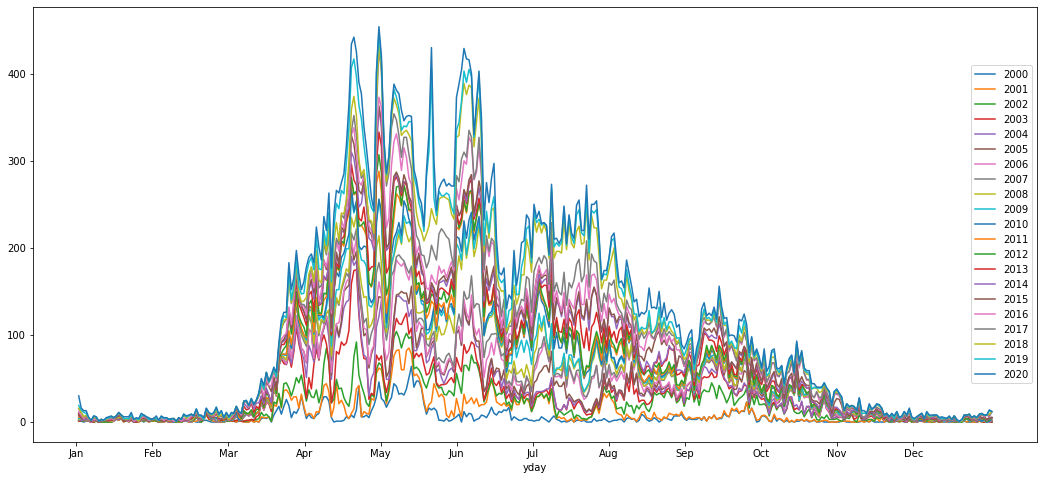

In [101]:

line = fig3.plot(kind='line',y='Sum', stacked=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
#line.set_xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
#line.set_xticklabels(fires_month['Month'].values)
line.legend(loc='center right')


In [102]:
fig4 = fires_day_month_v2.groupby(['yday','year_group']).median().unstack()

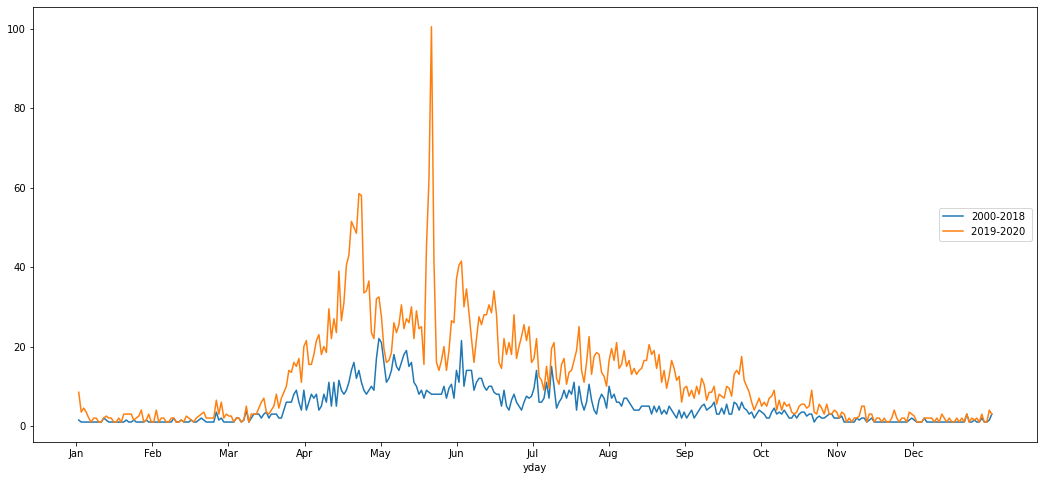

In [103]:
line = fig4.plot(kind='line',y='Sum', stacked=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
line.legend(loc='center right')
plt.show()

In [104]:
fig5 = fires_day_month_v2.groupby(['yday','year_group']).mean().unstack()

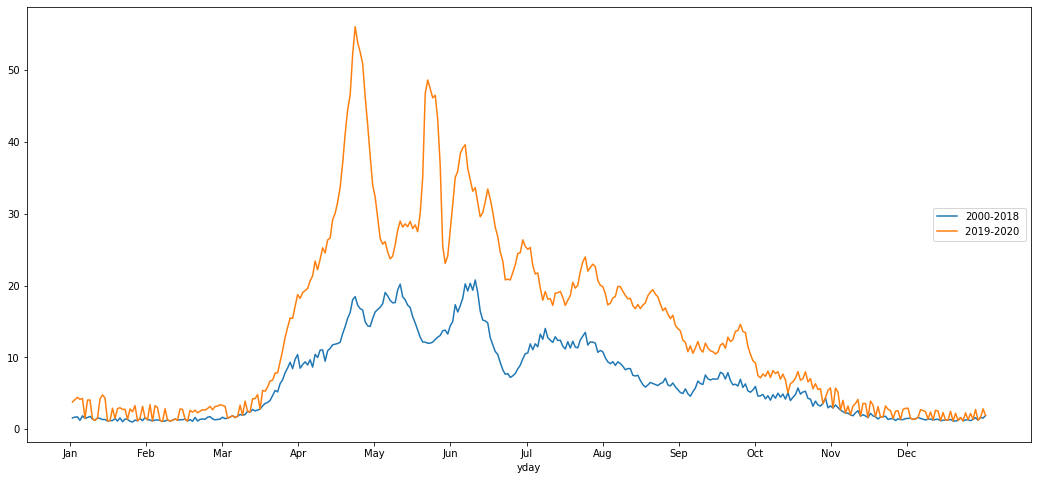

In [105]:
line2 = fig5.plot(kind='line',y='rol7', stacked=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
line2.legend(loc='center right')
plt.show()

In [106]:
fig2 = fires_day_month.drop(columns=['day','month','Year'])
fig2 = fires_day_month.groupby(['yday']).sum().unstack()

In [107]:
#At this point we remove Latitude and Longitude NaNs. We could replace these with other values in the future maybe?
sample = sample[sample['Latitude'].notna()]
sample = sample[sample['Longitude'].notna()]
fire_muni = sample
fire_muni = fire_muni[['datum','kommunKortNamn']]

In [108]:
allyears = pd.DataFrame(columns=['fires'])
tt = fire_muni.set_index(['datum'])
fire_muni_pre2019 = tt.loc['2000-01-01':'2018-12-31']
fire_muni_pre2019['year_group'] = '2000-2018'
fire_muni_post2018 = tt.loc['2019-01-01' : '2020-12-31']
fire_muni_post2018['year_group'] = '2019-2020'
fire_muni_fires12to18 = tt.loc['2012-01-01' : '2018-12-31']
fire_muni_post2018.sort_values(by='datum')
allyears = pd.concat([fire_muni_pre2019,fire_muni_post2018])
allyears = allyears.assign(fires=1)
allyears= allyears.reset_index()



C:\Users\Johan\AppData\Local\Temp/ipykernel_27580/2929753410.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_muni_pre2019['year_group'] = '2000-2018'
C:\Users\Johan\AppData\Local\Temp/ipykernel_27580/2929753410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_muni_post2018['year_group'] = '2019-2020'


In [109]:
#allyears['kommunKortNamn'] = allyears['kommunKortNamn'].replace('Malung','Malung-Sälen')


In [110]:
#You are here
allyears = allyears.set_index(['datum'])
pre2019 = allyears.loc['2000-1-1':'2018-12-31']
post2018 = allyears.loc['2019-1-1' : '2020-12-31']
pre2019
allyears= allyears.groupby(allyears['kommunKortNamn']).sum()
allyears =allyears.reset_index()


In [111]:
ch_df_pre2019= pre2019.groupby(pre2019['kommunKortNamn']).sum()
ch_df_pre2019 =ch_df_pre2019.reset_index()

In [112]:
#Instansiate folium map with starting point over sweden.
map = folium.Map(location = [59.334591, 18.063240],
               zoom_start = 5.45)

with open('./data/sweden-municipalities-topo.json',encoding='utf-8') as f:
    muni_topo = json.load(f)

#Create Choropleth with data from allyears dataframe.
folium.Choropleth(geo_data=muni_topo,
    topojson='objects.SWE_adm2',
    key_on='feature.properties.NAME_2',
    data=allyears, # What dataset to visualize
    columns=['kommunKortNamn','fires'], 
    fill_color='OrRd', 
    fill_opacity=0.9, 
    line_opacity=0.5,
    legend_name="Number of reported fires",
    threshold_scale=[1,25,50,100,200,400,800,1600,3200,6400]
    ).add_to(map)
map.save('./data/AllReportedFires.html')
map

In [113]:
#Possibly add something like this too the map so hoover shows name etc.

#tooltip=folium.features.Tooltip(fields=['name',variable,],
#                                              aliases=['State','2015 Median Income'], 
#                                              labels=True, 
 #                                             sticky=True,
 #                                             toLocaleString=True
  #                                           )

In [114]:
#MAP variant 2 (not as good in my opinion)

#Json file with polygon coordinates for municipalities and names to use.
muni_topo = json.load(open('./data/sweden-municipalities-topo.json',encoding='utf-8'))

#Linear colormap for showing different colors
linear = folium.LinearColormap(['green','yellow','red'], vmin=000, vmax=allyears['fires'].max())
color_dict = {key: linear(allyears_dict[key]) for key in allyears_dict.keys()}

m = folium.Map(location = [59.334591, 18.063240],
               zoom_start = 5.5)

style_function = lambda feature: {'fillColor': color_dict[feature['properties']['NAME_2']],
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5'}

folium.TopoJson(muni_topo,'objects.SWE_adm2',name="topojson",style_function=style_function,


).add_to(m)
  
m

NameError: name 'allyears_dict' is not defined

In [ ]:
#Function that takes the dataframe and returns a map. Circles on the map are colored based on the size of the fire.
def add_FireCircle(df, m):
    for i, v in df.iterrows():
        
        fire_size = float(v['Acres'])
        
        #When hoovering over the circle, the popup will show the fire name, year, cause, state and size.
        #More values can be added.
        popup = """
        Kommun : <b>%s</b><br>
        Size (Acres) : <b>%s</b><br>
        Cause : <b>%s</b><br>
        Year: <b>%s</b><br>
        """ % (v['kommunKortNamn'], v['Acres'], 
            v['BEJBbrandorsakText'], 
            v['ar'])
        
        
        if fire_size < 100:
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 0.8,
                            weight = 0,
                            tooltip = popup,
                            color = '#ffeda0',
                            fill_color = '#ffeda0',
                            fill_opacity = 0.7,
                            fill = True).add_to(small_wildfires)
            
        if fire_size in range(100, 500):
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size),
                            weight = 0,
                            tooltip = popup,
                            color = '#feb24c',
                            fill_color = '#feb24c',
                            fill_opacity = 0.7,
                            fill = True).add_to(medium_wildfires)
        
        if fire_size in range(1000, 5000):
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 1.5,
                            weight = 0,
                            tooltip = popup,
                            color = '#fc4e2a',
                            fill_color = '#fc4e2a',
                            fill_opacity = 0.7,
                            fill = True).add_to(large_wildfires)

        if fire_size > 5000:
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 2,
                            weight = 0,
                            tooltip = popup,
                            color = '##b10026',
                            fill_color = '#b10026',
                            fill_opacity = 0.7,
                            fill = True).add_to(xl_wildfires)

    small_wildfires.add_to(m)
    medium_wildfires.add_to(m)
    large_wildfires.add_to(m)
    xl_wildfires.add_to(m)
    folium.LayerControl(collapsed = False).add_to(m)

    return m

In [ ]:
#Map instanciation, with start point at the center of Sweden. Type of map is set to Stamen Terrain and zoom is set to 5.5 in the beginning.
map = folium.Map(location = [59.334591, 18.063240],
               tiles = 'Stamen Terrain',
               zoom_start = 5.5)

In [ ]:
small_wildfires = folium.FeatureGroup(name = '< 10000 Acres')
medium_wildfires = folium.FeatureGroup(name = '10,000 - 50,000 Acres')
large_wildfires = folium.FeatureGroup(name = '50,000 - 100,000 Acres')
xl_wildfires = folium.FeatureGroup(name = '> 100,000 Acres')

In [ ]:
#Creating Ciricle map (FYI! Can take som time!)
m_sweden = add_FireCircle(sample, map)
m_sweden
#m_sweden.save('sweden.html')

In [ ]:
#Creating heatmap for sample
locations = sample[['Latitude','Longitude']]
h_sweden = add_ToHeatMap(locations.values,map)

In [ ]:
h_sweden